<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [33]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

import time 
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

RND = 12345

In [34]:
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [36]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [37]:
data = data.set_index('datetime')
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.index.is_monotonic

True

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Датасет состоит из столбцов datetime - дата и время, num_orders - количество заказов такси, количество строк  4416, пропуски отсутствуют. Мы создали датасет с индексами временного ряда, проверили на монотонность и рассемплировали данные по 1 часу.

## Анализ

Построим график с разбивкой по часу

<AxesSubplot:title={'center':'Количество заказов такси'}, xlabel='datetime'>

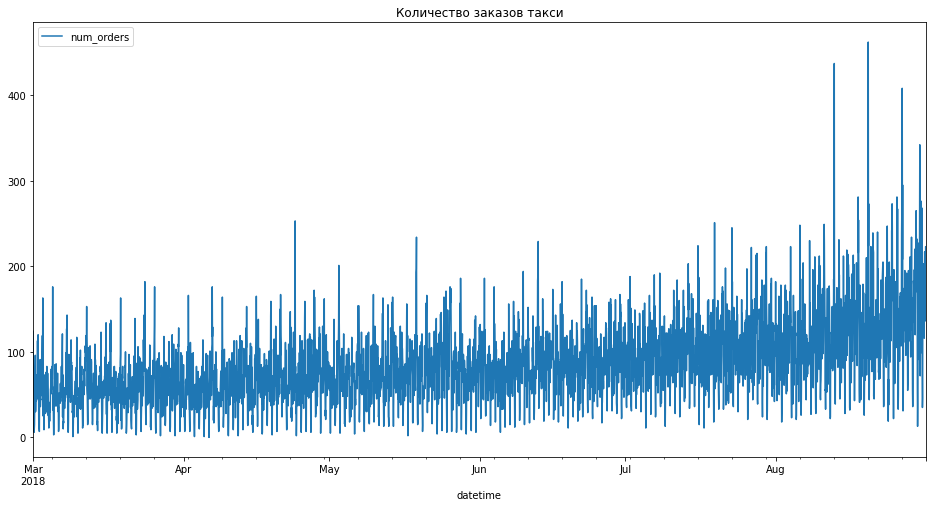

In [39]:
data.plot(figsize=(16,8), title="Количество заказов такси")

Посмотрим на тренд и сезонность

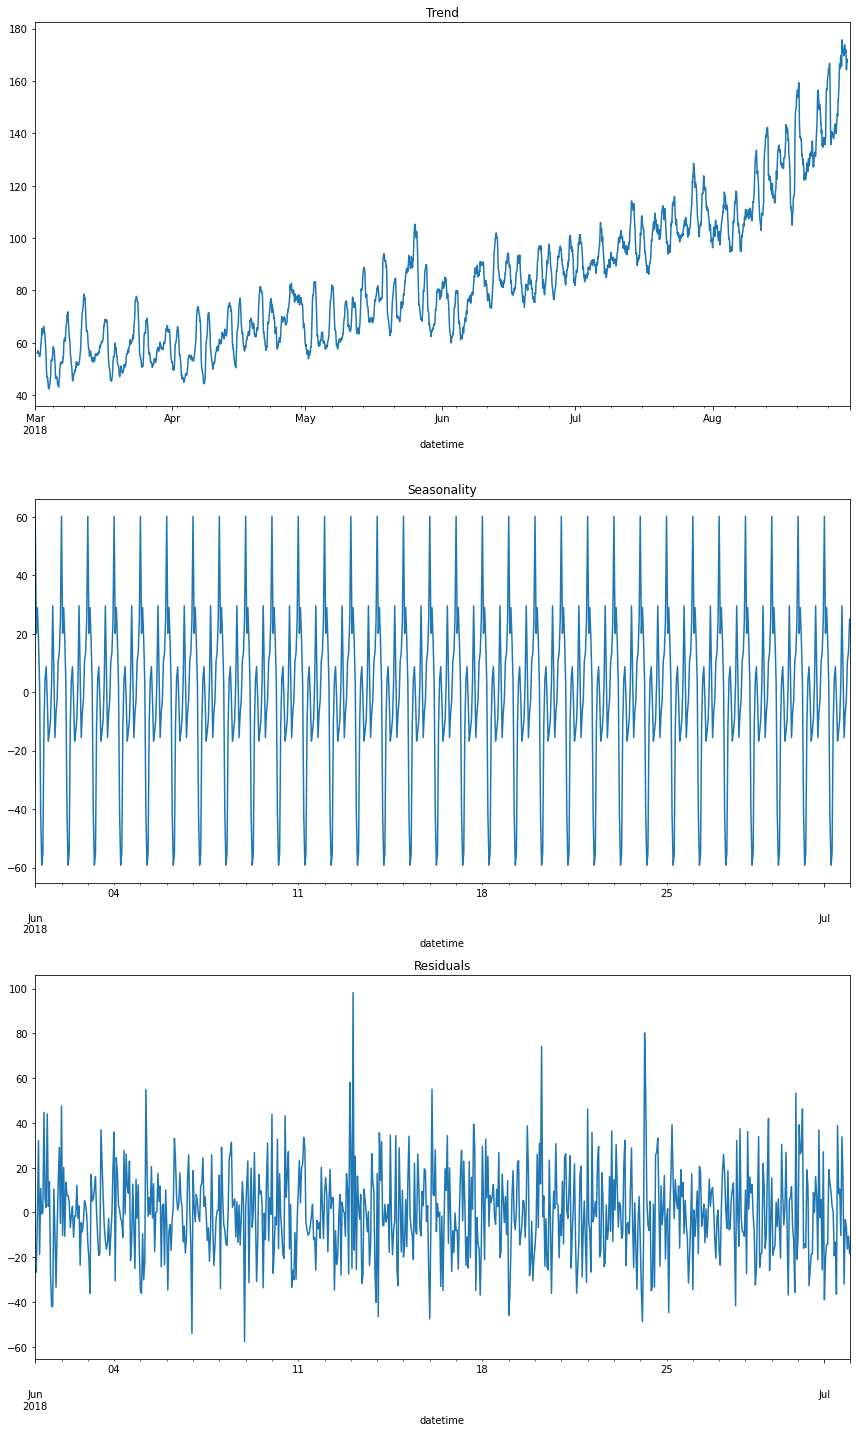

In [40]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-07-01'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-06-01':'2018-07-01'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим, что тренд имеет восходящий характер - увеличение количества заказов такси от месяца к месяцу. Период сезонности соответствует примерно неделе.

Рассмотрим график сезонности в разрезе недели и одних суток.

<AxesSubplot:title={'center':'Сезонность заказов в течение первых 7 дней августа'}, xlabel='datetime'>

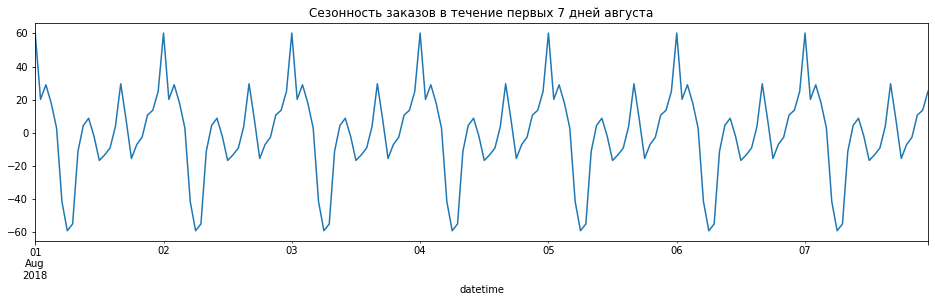

In [41]:
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в течение первых 7 дней августа")
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())

<AxesSubplot:title={'center':'Сезонность заказов в течение первых 2 дней августа'}, xlabel='datetime'>

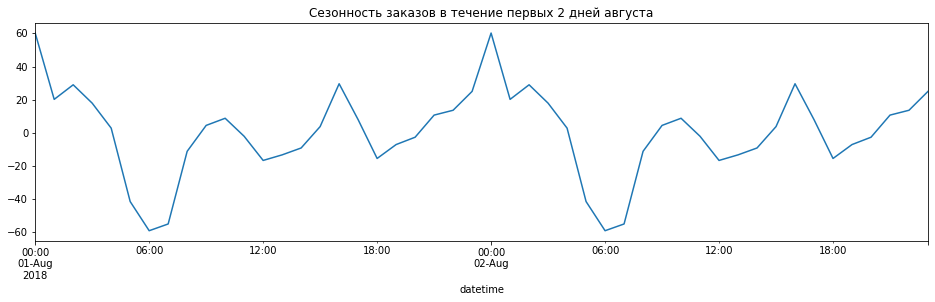

In [42]:
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в течение первых 2 дней августа")
decomposed.seasonal['2018-08-01':'2018-08-02'].plot()

Теперь явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

## Обучение

Создадим признаки для обучения модели (месяц, день, день недели, час)

In [43]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [44]:
make_features(data, 2, 24)

In [45]:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,56.958333


In [46]:
data = data.dropna()

In [47]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']

Разобьем данные на тестовую и обучающую выборки в соотношении 90:10

In [48]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=RND, shuffle=False)

In [49]:
print(features_train.index.is_monotonic)
print(features_test.index.is_monotonic)
print(target_train.index.is_monotonic)
print(target_test.index.is_monotonic)

True
True
True
True


Создадим функцию подсчета метрики RMSE

In [50]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### LinearRegression

In [51]:
%%time
my_cv = TimeSeriesSplit(n_splits=8).split(features_train)
#Объявляю модель
model1 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
#Обучаю модель
model1.fit(features_train, target_train)
#Определяю RMSE модели с помощью кросс-валидации
model1_score = pd.Series(cross_val_score(model1,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', model1_score)

Среднее качество модели линейной регрессии на кросс-валидации: 31.377411422489164
CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 41.2 ms


### RandomForestRegressor

In [ ]:
%%time

my_cv = TimeSeriesSplit(n_splits=8).split(features_train)
#Объявляю модель
model2 = RandomForestRegressor()
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

#Применяю GridSearchCV с кросс-валидацией
model2_grid = GridSearchCV(model2, forest_parametrs, scoring=RMSE_score, cv=my_cv)
model2_grid.fit(features_train, target_train)

In [114]:
model2_params = model2_grid.best_params_
#forest_score = model2_grid.score(features_train, target_train) * (-1)
model2_score = model2_grid.best_score_ * (-1)


print(model2_params)
print(model2_score)

{'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 25}
27.29068705879591


### CatBoostRegressor

In [53]:
%%time

my_cv = TimeSeriesSplit(n_splits=8).split(features_train)
#Объявляю модель
model3 = CatBoostRegressor()
#Определяю словарь с набором параметров
cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

#Применяю GridSearchCV с кросс-валидацией
model3_grid = GridSearchCV(model3, cb_parametrs, scoring=RMSE_score, cv=my_cv)
model3_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8924166	total: 46.5ms	remaining: 46.5s
100:	learn: 17.4855500	total: 74.9ms	remaining: 666ms
200:	learn: 15.5791106	total: 102ms	remaining: 407ms
300:	learn: 14.1950628	total: 131ms	remaining: 304ms
400:	learn: 13.1494159	total: 159ms	remaining: 238ms
500:	learn: 12.3965562	total: 187ms	remaining: 187ms
600:	learn: 11.7351567	total: 215ms	remaining: 143ms
700:	learn: 11.1446903	total: 243ms	remaining: 104ms
800:	learn: 10.6492713	total: 271ms	remaining: 67.3ms
900:	learn: 10.1930142	total: 302ms	remaining: 33.2ms
999:	learn: 9.7693480	total: 331ms	remaining: 0us
0:	learn: 29.0620612	total: 524us	remaining: 524ms
100:	learn: 19.0861084	total: 39.3ms	remaining: 350ms
200:	learn: 17.6181368	total: 73.6ms	remaining: 292ms
300:	learn: 16.4052472	total: 113ms	remaining: 263ms
400:	learn: 15.5203192	total: 150ms	remaining: 224ms
500:	learn: 14.8469401	total: 183ms	remaining: 182ms
600:	learn: 14.3085392	total: 219ms	remaining: 145ms
700:	learn: 13.8522807	total: 254ms	remaining: 

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f24a530aa50>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f24a566f5b0>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [54]:
%%time

model3_params = model3_grid.best_params_
#cb_score = model3_grid.score(features_train, target_train) * (-1)
model3_score = model3_grid.best_score_ * (-1)

print(model3_params)
print(model3_score)

{'depth': 4, 'learning_rate': 0.03}
24.60193304014663
CPU times: user 263 µs, sys: 10 µs, total: 273 µs
Wall time: 175 µs


In [117]:
result = pd.DataFrame(
    [model1_score, model2_score, model3_score], 
    index=['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'], 
    columns=['RMSE']
)
result

,RMSE
LinearRegression,29.101419
RandomForestRegressor,27.290687
CatBoostRegressor,26.164125


Самая лучшая модель по показателю RMSE это у CatBoostRegressor, с показателем 26,16

## Тестирование

In [55]:
model3_predict = model3_grid.predict(features_test)
RMSE(target_test, model3_predict)

47.130598074224096

Text(0.5, 1.0, 'Результаты модели')

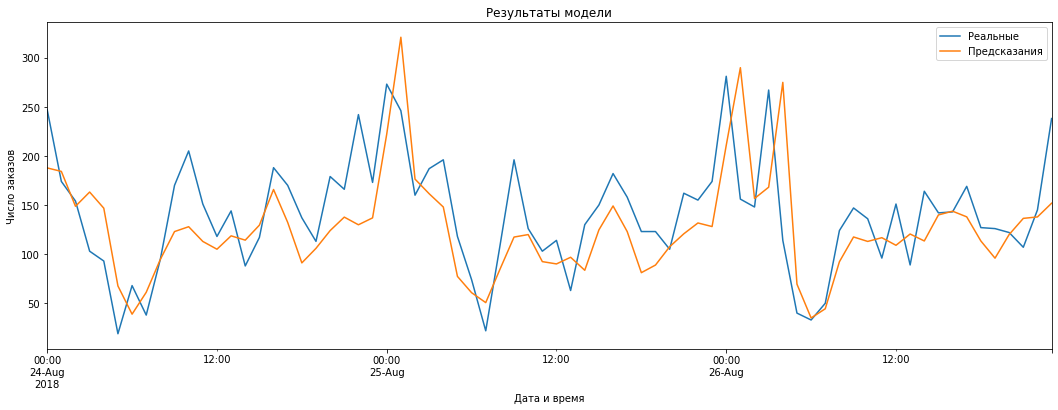

In [56]:
model_result = pd.DataFrame({"Реальные":target_test, "Предсказания":model3_predict})
model_result['2018-08-24':'2018-08-26'].plot(figsize=(18, 6), xlabel='Дата и время', ylabel='Число заказов')
plt.title("Результаты модели")

Была произведена предварительная подготовка данных, был изменен тип данных столца datetime на тип datetime64 и установлены данные значения в качестве индексов, произведена проверка данных на монотонность.

Выявили, что тренд количества заказов увеличивается от месяца к месяцу, период сезонности соответствует примерно неделе.

В рамках одной недели наибольшее количество заказов в понедельник и пятницу, а минимальное вторник и воскресенье.

В рамках суток пик заказов приходится на полночь, наименьшее количество заказов соотвествует 6 часам утра.

Мы обучили модели LinearRegression, RandomForestRegressor, CatBoostRegressor. Проверив модели на тестовых выборках мы выяснили что модель CatBoostRegressor дает лучшие показатели RMSE обучающей выборки 26.16, для тестовой - 47

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48